# Workflow for a Example Grid Simplification

In this application, we showcase the capability for pre-process network graphs and simplify their topologies

The workflow is structured as follows:
1. Import relevant modules / tools / packages
2. Separate lines into smaller section
3. Cut lines at crossings
4. Alternative Option: Use workflow for the creation of smaller lines and separate at crossings  
5. Split Lines into segments of predefined size

## 1. Import relevant modules / tools / packages

In [1]:
from HIM.workflow.scenarioExample import *

In [2]:
from HIM import dataHandling as sFun
from HIM import optiSetup as optiFun
from HIM import hscTotal
from HIM import plotFunctions as pFun
from HIM.workflow import preprocFunc as preFun   

In [3]:
dataPathExample=path.join(dataPath,"GridExampleInputs")

In [4]:
pathGasL = path.join(dataPathExample,"ExampleGridNaturalGas")
pathDist= path.join(dataPathExample,"area")

In [5]:
gpdLines=sFun.import_shp(pathGasL, crs=crs)
area=sFun.import_shp(pathDist, crs=crs)

In [6]:
def plot_shape(figsize=(7,10), facecolor="white"):
    unary=gpd.GeoSeries([area.unary_union])
    ax=unary.plot(facecolor=facecolor, figsize=figsize)
    ax.xaxis.set_ticklabels(["" for x in ax.xaxis.get_ticklabels()])
    ax.yaxis.set_ticklabels(["" for x in ax.yaxis.get_ticklabels()])
    ax.axis("off")
    ax.set_aspect("equal")
    return ax

The geopandas Dataframe has now linestrings which have long distances and no crossings implemented.

In [7]:
sFun.simple_gpd(gpdLines)
gpdPoints=sFun.rem_dupl_un(gpdLines)

In [8]:
cmap="nipy_spectral"

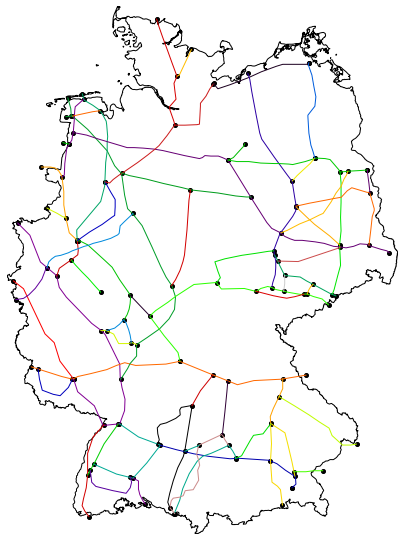

In [9]:
gpdLines["color"]=[np.random.rand() for x in gpdLines.index]
ax=plot_shape()
gpdLines.plot(ax=ax, cmap=cmap, column="color")
gpdPoints.plot(ax=ax, color="black")
plt.show()

## 2. Separate lines into smaller section

First, we have to separate the lines into smaller sections

In [10]:
singleLines=[]
for line in gpdLines.geometry:
    length=len(line.coords)
    for x in range(length-1):
        singleLines.append(LineString([line.coords[x], line.coords[x+1]]))
gpdLinesSingle=gpd.GeoDataFrame(geometry=singleLines)
gpdLinesSingle["ID"]=gpdLinesSingle.index

In [11]:
sFun.simple_gpd(gpdLinesSingle)
gpdPointsSingle=sFun.rem_dupl_un(gpdLinesSingle)

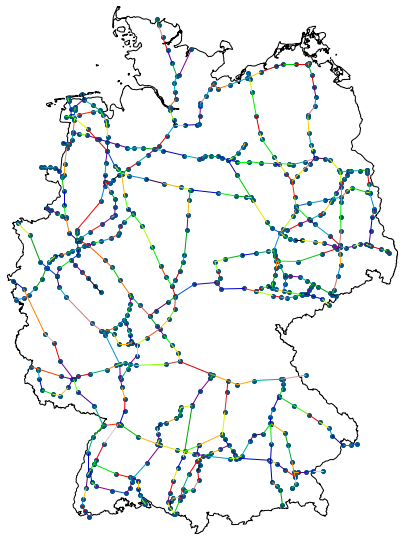

In [12]:
gpdLinesSingle["color"]=[np.random.rand() for x in gpdLinesSingle.index]
ax=plot_shape()
gpdLinesSingle.plot(ax=ax,column="color", cmap=cmap)
gpdPointsSingle.plot(ax=ax)
plt.show()

## 3. Cut lines at crossings

As a next step, we cut the lines at crossings

In [13]:
newLines=[]
for key, values in gpdLinesSingle.iterrows():
    iterSectionsBool=gpdLinesSingle.intersects(values["geometry"])
    iterSections=gpdLinesSingle.intersection(values["geometry"]).loc[iterSectionsBool]
    iterPoints=iterSections.loc[iterSections.index!=key]
    if iterPoints.size>0:
        lines=sFun.cutLineAtPoints(values["geometry"],[iterPoints[x] for x in iterPoints.index])
        newLines.extend(lines)
    else:
        newLines.append(values["geometry"])

In [14]:
gpdLinesFinal=gpd.GeoDataFrame(geometry=newLines)
gpdLinesFinal.crs=gpdLines.crs
sFun.simple_gpd(gpdLinesFinal)
gpdPointsFinal=sFun.rem_dupl_un(gpdLinesFinal)
gpdPointsFinal.index=gpdPointsFinal["coords"]
gpdLinesFinal["inputID"]=gpdPointsFinal.loc[gpdLinesFinal["coordsIn"].values, "ID"].values
gpdLinesFinal["targetID"]=gpdPointsFinal.loc[gpdLinesFinal["coordsOut"].values, "ID"].values
gpdLinesFinal=gpdLinesFinal.loc[[values["inputID"]!=values["targetID"] for key, values in gpdLinesFinal.iterrows()]].copy()
gpdLinesFinal["ID"]=[(values["inputID"],values["targetID"]) for key, values in gpdLinesFinal.iterrows()]
gpdLinesFinal=gpdLinesFinal.loc[gpdLinesFinal["ID"].drop_duplicates().index]

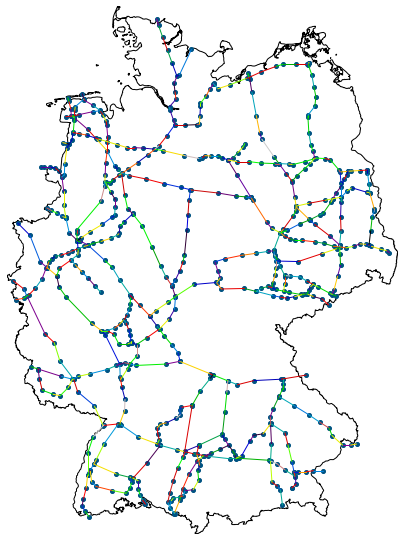

In [15]:
gpdLinesFinal["color"]=[np.random.rand() for x in gpdLinesFinal.index]
ax=plot_shape()
gpdLinesFinal.plot(ax=ax, cmap=cmap, column="color")
gpdPointsFinal.plot(ax=ax)
plt.show()

## 4. Alternative Option: Use workflow for the creation of smaller lines and separate at crossings

The workflow is already setup in a function called: sFun.simplifyLinesandCrossings()

In [16]:
gpdLinesFinal2, gpdPointsFinal2=sFun.simplifyLinesAndCrossings(gpdLines)

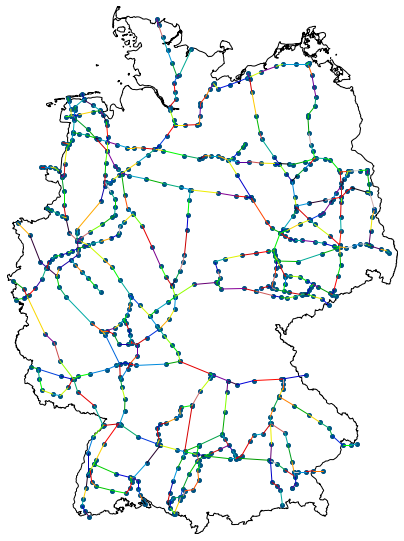

In [17]:
gpdLinesFinal2["color"]=[np.random.rand() for x in gpdLinesFinal2.index]
ax=plot_shape()
gpdLinesFinal2.plot(ax=ax, cmap=cmap, column="color")
gpdPointsFinal2.plot(ax=ax)
plt.show()

## 5. Split Lines into segments of predefined size

Since we want to decrease the ways besides that waypoints, we can additially cut all lines based on a maximal distance

In [18]:
gpdLinesSplit=sFun.splitLinesOnMaxDistance(gpdLinesFinal, lMax=1000).T

In [19]:
sFun.simple_gpd(gpdLinesSplit)
gpdPointsSplit=sFun.rem_dupl_un(gpdLinesSplit)

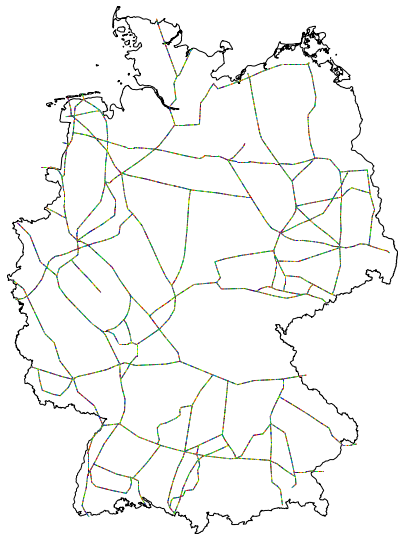

In [20]:
gpdLinesSplit["color"]=[np.random.rand() for x in gpdLinesSplit.index]
ax=plot_shape()
gpdLinesSplit.plot(ax=ax, cmap=cmap, column="color")
#gpdPointsSplit.plot(ax=ax,markersize=5)
plt.show()

In [21]:
gpdPointsSplit.index=gpdPointsSplit["coords"]
gpdLinesSplit["inputID"]=gpdPointsSplit.loc[gpdLinesSplit["coordsIn"].values, "ID"].values
gpdLinesSplit["targetID"]=gpdPointsSplit.loc[gpdLinesSplit["coordsOut"].values, "ID"].values
gpdLinesSplit=gpdLinesSplit.loc[[values["inputID"]!=values["targetID"] for key, values in gpdLinesSplit.iterrows()]].copy()
gpdLinesSplit["ID"]=[(values["inputID"],values["targetID"]) for key, values in gpdLinesSplit.iterrows()]
gpdLinesSplit=gpdLinesSplit.loc[gpdLinesSplit["ID"].drop_duplicates().index]